# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [1]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
- [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
- [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

## Предварительный анализ

Считывание данных.

In [2]:
import json
import pandas as pd

with open('train.jsonl', 'r') as json_file:
    train_list = list(json_file)

with open('dev.jsonl', 'r') as json_file:
    dev_list = list(json_file)

train_df = pd.DataFrame([json.loads(jline) for jline in train_list])
dev_df = pd.DataFrame([json.loads(jline) for jline in dev_list])
df = pd.DataFrame([json.loads(jline) for jline in train_list + dev_list])
df.head()

,question,title,answer,passage
0,do iran and afghanistan speak the same language,Persian language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,Good Samaritan law,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,Windows Movie Maker,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,Powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online,False,As with other games in The Elder Scrolls serie...


Подготовка фреймворка для препроцессинга.

In [3]:
import string, re, nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

nltk.download('wordnet')
wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    return ' '.join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Получение текстов после препроцессинга.

In [4]:
train_df['nltk_question'] = train_df['question'].apply(preproc_nltk)
dev_df['nltk_question'] = train_df['question'].apply(preproc_nltk)
df['nltk_question'] = train_df['question'].apply(preproc_nltk)

train_df['nltk_passage'] = train_df['passage'].apply(preproc_nltk)
dev_df['nltk_passage'] = train_df['passage'].apply(preproc_nltk)
df['nltk_passage'] = train_df['passage'].apply(preproc_nltk)


Распределение лейблов почти одинаковое как в train части, так и в dev.

In [5]:
display(df.answer.value_counts(normalize=True))
display(train_df.answer.value_counts(normalize=True))
display(dev_df.answer.value_counts(normalize=True))

True     0.622746
False    0.377254
Name: answer, dtype: float64

True     0.623104
False    0.376896
Name: answer, dtype: float64

True     0.621713
False    0.378287
Name: answer, dtype: float64

Среднее количество слов в вопросе почти одинаково как до, так и после обработки.

In [6]:
print(round(df.question.str.split().str.len().mean(), 1))
print(round(train_df.question.str.split().str.len().mean(), 1))
print(round(dev_df.question.str.split().str.len().mean(), 1))

8.8
8.8
8.7


In [7]:
print(round(df.nltk_question.str.split().str.len().mean(), 1))
print(round(train_df.nltk_question.str.split().str.len().mean(), 1))
print(round(dev_df.nltk_question.str.split().str.len().mean(), 1))

4.6
4.6
4.6


На train части вопросы до обработки длиннее на 1 слово, но после обработки длина почти не отличается.

In [8]:
print(round(df.passage.str.split().str.len().mean(), 1))
print(round(train_df.passage.str.split().str.len().mean(), 1))
print(round(dev_df.passage.str.split().str.len().mean(), 1))

92.9
93.2
92.2


In [9]:
print(round(df.nltk_passage.str.split().str.len().mean(), 1))
print(round(train_df.nltk_passage.str.split().str.len().mean(), 1))
print(round(dev_df.nltk_passage.str.split().str.len().mean(), 1))

56.8
56.8
56.6


*Queries that are likely to be yes/no questions are heuristically identified: we found selecting queries where the first word is in a manually constructed set of indicator words and are of sufficient length, to be effective.*

*The full set is: {“did”, “do”, “does”, “is”, “are”, “was”, “were”, “have”, “has”, “can”, “could”, “will”, “would”}.*

*... use questions that were marked as having a yes/no answer, and pair each question with the selected passage instead of the entire document.*


Все вопросы начинаются с одного из выбранных маркеров в приведенном списке. Из-за этого у вопросов будет заранее заданная структура, под которую может подстраиваться модель. Вполне возможно, поэтому в тексте будут классические прямые вопросы в формальном стиле, задающие вопрос про конкретный вопрос. Не будет неформальных вопросов со свободном порядком предложения, tag questions, вопросов с отрицанием или фактов, которые нужно подтвердить или опровергнуть.

Кроме того, в качестве пассажа бралась та часть текста, в которой содержится ответ на вопрос. То есть, модели будет намного проще определить ключевые моменты текста.

Рассмотрим первые слова вопросов. Самые популярные слова - те, что приведены в списке выше и выбраны авторами датасета.

In [10]:
df.question.str.split().str[0].value_counts().head(30)

is           5722
can          1530
does         1325
are           944
do            907
did           595
was           439
has           426
will          249
have           95
the            91
were           42
in             35
if             17
a              16
what           11
could          11
when           10
would           6
where           5
who             5
an              4
why             3
true            3
my              3
should          2
according       2
by              2
nilgiri         2
didn't          2
Name: question, dtype: int64

Если мы посмотрим на вопросы, которые начинаются с других слов, то мы увидим, что большинство с точностью до перестановки части фразы являются ровно теми же вопросами с нужным первым словом (а так начинаются с указания контекста), некоторые представляют собой усеченные вопросы, которые при добавлении правильного auxiliary verb (глагола из списка) становятся вопросами нужной формы. Хотя на самом деле, эти вопросы больше похожи на факты, которые нужно доказать или опровергнуть. Некоторые вопросы содержат в своем тексте сочетание "true or false", что указывает на наличие факта, которому нужно выдать вердикт.

Также встретились некоторые вопросы с отрицанием.

Кроме того, есть вопросы, которые не подразумевают ответ да/нет, например, "who does denzel washington play in remember the titans".

Получается, что в датасете встречаются запросы самого различного характера, которые не обязательно соответствуют указанной в статье структуре. Они могут быть релевантными, но плохо сформулированными, могут быть нерелевантными. Такая разноплановость корпуса возможно может приводить модели в замешательство, так как ей будет тяжело вычленить нужную семантику из вопроса, так как она не может догадаться, в какой форме вопрос придет. Это может сильно усложнить процесс обучения и результаты модели. Тем не менее, если обучать ее на "правильных" запросах, которые описаны в статье, то модель будет плохо показывать себя на практике, так как на практике вопросы могут быть такими же сумбурными и случайным как в датасете, поэтому их удаление не поможет.

In [11]:
df.question[~df.question.str.split().str[0] \
                  .isin(["did", "do", "does", "is", "are", "was", "were", 
                         "have", "has", "can", "could", "will", "would"])].tolist()

['calcium carbide cac2 is the raw material for the production of acetylene',
 'the boy in the plastic bubble based on true story',
 'science begins with the premise that knowledge should first be acquired through observation',
 'in the phantom menace is padme the queen',
 'you can tell a lot about a person by how they treat their waiter',
 'several cranial nerves innervate structures of the tongue',
 'the movie rudy based on a true story',
 'the former soviet union broke into separate states',
 'paths from the cerebral cortex to the spinal cord are called the corticospinal tracts',
 'true or false anaphylaxis generally only affects the skin and eyes',
 'when sandy hit nj was it a hurricane',
 'during his lifetime an athenian citizen could serve on the council of five hundred',
 'the visual cliff is a device for studying',
 'the long road home is it a series',
 'if a table contains a primary key there can be no duplicate records in a table',
 'the main component of stomach acid is sulfu

## Подходы 1-2. Константа и fasttext

In [12]:
from sklearn.metrics import accuracy_score

In [28]:
val_df = train_df.sample(frac=0.2, random_state=10)
train_df = train_df[~train_df.index.isin(val_df.index)]

In [ ]:
y_pred = [train_df.answer.value_counts().index[0]] * len(dev_df)

print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

62.17


fasttext

In [ ]:
# import gensim
# import gensim.downloader as api

# fasttext = api.load("fasttext-wiki-news-subwords-300")

In [ ]:
!pip install fasttext

import fasttext

     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3096663 sha256=4438969f5fe99a5117c3f6f0e874f50a89892d64c494e55c01c7a6491c4be12b
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
train_df['concat_question_passage'] = train_df.question + ' ' + train_df.passage
val_df['concat_question_passage'] = val_df.question + ' ' + val_df.passage
dev_df['concat_question_passage'] = dev_df.question + ' ' + dev_df.passage

In [ ]:
train_df['fasttext_label'] = '__label__' + train_df.answer.astype(str)
val_df['fasttext_label'] = '__label__' + val_df.answer.astype(str)
dev_df['fasttext_label'] = '__label__' + dev_df.answer.astype(str)

In [ ]:
train_df[['fasttext_label', 'concat_question_passage']] \
          .to_csv('fasttext_train.txt', index=False, sep=' ', header=False)
val_df[['fasttext_label', 'concat_question_passage']] \
          .to_csv('fasttext_val.txt', index=False, sep=' ', header=False)
dev_df[['fasttext_label', 'concat_question_passage']] \
          .to_csv('fasttext_dev.txt', index=False, sep=' ', header=False)

Поиграюсь с параметрами fasttext.

In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_train.txt',
                                  epoch = 10, wordNgrams = 3, dim=100,
                                  autotuneValidationFile='fasttext_val.txt')

y_pred = fasttext_model.predict(dev_df['concat_question_passage'].tolist())
bool_dict = {'True': True, 'False': False}

y_pred = [bool_dict[pred[0].split('__')[-1]] for pred in y_pred[0]]
print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

67.83


In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_train.txt',
                                  epoch = 10, wordNgrams = 3, dim=50,
                                  autotuneValidationFile='fasttext_val.txt')

y_pred = fasttext_model.predict(dev_df['concat_question_passage'].tolist())
bool_dict = {'True': True, 'False': False}

y_pred = [bool_dict[pred[0].split('__')[-1]] for pred in y_pred[0]]
print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

68.29


In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_train.txt',
                                  epoch = 10, wordNgrams = 5, dim=100,
                                  autotuneValidationFile='fasttext_val.txt')

y_pred = fasttext_model.predict(dev_df['concat_question_passage'].tolist())
bool_dict = {'True': True, 'False': False}

y_pred = [bool_dict[pred[0].split('__')[-1]] for pred in y_pred[0]]
print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

68.47


In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_train.txt',
                                  epoch = 20, wordNgrams = 5, dim=100,
                                  autotuneValidationFile='fasttext_val.txt')

y_pred = fasttext_model.predict(dev_df['concat_question_passage'].tolist())
bool_dict = {'True': True, 'False': False}

y_pred = [bool_dict[pred[0].split('__')[-1]] for pred in y_pred[0]]
print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

67.95


In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_train.txt', lr=0.7,
                                  epoch = 10, wordNgrams = 5, dim=100,
                                  autotuneValidationFile='fasttext_val.txt')

y_pred = fasttext_model.predict(dev_df['concat_question_passage'].tolist())
bool_dict = {'True': True, 'False': False}

y_pred = [bool_dict[pred[0].split('__')[-1]] for pred in y_pred[0]]
print(round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2))

68.38


Лучшие результаты при большем learning rate, меньшем размере эмбеддинга и большем числе эпох. Модель показывает результат примерно 68-68.5%, что всего на 6% лучше константы.

FastText справляется плохо, так как он не различает вопрос и пассаж, поэтому не всегда может понимать, что нужно искать связь между словами в вопросе и в пассаже.Модель воспринимает все как один текст, когда вопрос и пассаж стоило бы оценивать отдельно, чтобы выделять их отдельные особенности. Кроме того, так как он смотрит на морфемы, то он может терять мог верхнеуровневой абстрактной информации, которая нужна для нахождения нужного контекста в вопросе.

## Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [13]:
import torch
!pip install transformers
from transformers import BertTokenizer, BertModel, \
                         DistilBertTokenizer, DistilBertModel, \
                         BertForQuestionAnswering, \
                         RobertaTokenizer, RobertaModel,\
                         LongformerTokenizer, LongformerModel
from sklearn.linear_model import LogisticRegression
import numpy as np
import gc
import tqdm

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.WARNING)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.0 MB/s eta 0:00:00


In [14]:
import tqdm
from IPython.display import clear_output
def get_emb(text_series, tokenizer, model, batch_size=32,
            truncation='longest_first',
            padding='max_length',
            max_length=512):

  text_series_padded = [tokenizer.encode(x,
                      add_special_tokens=True,
                      padding=padding,
                      truncation=truncation,
                      max_length=max_length) for x in text_series]
  
  text_series_padded = np.array(text_series_padded, dtype=np.int64)
  attention_mask = np.where(text_series_padded != 0, 1, 0)

  model.eval()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  output = []

  for idx in tqdm.tqdm(range(0, len(text_series_padded), batch_size)):

    batch = torch.tensor(text_series_padded[idx:idx + batch_size]).to(device)
    part_mask = torch.tensor(attention_mask[idx:idx + batch_size]).to(device)

    with torch.no_grad():
        release = model(batch, attention_mask=part_mask)
        output.append(release.last_hidden_state[:, 0, :].cpu())
    
    del release, batch, part_mask
    torch.cuda.empty_cache()

  return torch.cat(output, dim=0)

In [15]:
def get_accuracy(pretrained_weights, tokenizer, model, nltk=True,
                 truncation='longest_first',
                 padding='max_length',
                 max_length=512):

    tokenizer = tokenizer.from_pretrained(pretrained_weights)
    model = model.from_pretrained(pretrained_weights)

    if nltk:
    
        train_question_emb = get_emb(train_df.nltk_question, tokenizer, model, 
                                     batch_size=64)
        train_passage_emb = get_emb(train_df.nltk_passage, tokenizer, model, 
                                    batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
        
    else:

        train_question_emb = get_emb(train_df.question, tokenizer, model, 
                                     batch_size=64)
        train_passage_emb = get_emb(train_df.passage, tokenizer, model, 
                                    batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
        
    train_total_emb = torch.cat([train_question_emb, 
                                 train_passage_emb], dim=1).cpu().numpy()

    logreg = LogisticRegression()
    logreg.fit(train_total_emb, train_df.answer)

    del train_question_emb, train_passage_emb, train_total_emb
    gc.collect()

    if nltk:

        dev_question_emb = get_emb(dev_df.nltk_question, tokenizer, model,
                                   batch_size=64)
        dev_passage_emb = get_emb(dev_df.nltk_passage, tokenizer, model,
                                  batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)

    else:

        dev_question_emb = get_emb(dev_df.question, tokenizer, model,
                                   batch_size=64)
        dev_passage_emb = get_emb(dev_df.passage, tokenizer, model,
                                  batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
    
    dev_total_emb = torch.cat([dev_question_emb, 
                               dev_passage_emb], dim=1).cpu().numpy()

    y_pred = logreg.predict(dev_total_emb)
    ans = round(accuracy_score(y_pred, dev_df.answer.values) * 100, 2)

    del dev_question_emb, dev_passage_emb, dev_total_emb
    gc.collect()

    clear_output()

    return ans

Сначала я попробую применять DistilBert, так как он небольшой, быстрый и почти настолько же эффективный как обычный Bert. Я посмотрю на результат, для необработанных и обработанных текстов.

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel)

54.13

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=False)

65.54

Видно, что DistilBert на необработанных текстах значительно лучше (на 11%) показывает себя, чем на обработанных. Буду считать, что на обработанных текстах результаты лучше. Тем не менее, он не догоняет fasttext по результатам, проигрывая 2-3%, но лучше константной модели.

Дальше я посмотрю на обычный Bert.

In [ ]:
get_accuracy('bert-base-uncased', BertTokenizer, BertModel,
             nltk=True)

54.5

In [ ]:
get_accuracy('bert-base-uncased', BertTokenizer, BertModel,
             nltk=False)

64.01

Несмотря на чуть-чуть лучший результат для обработанных текстов, показатель для необработанных на целых 1.5% уступает DistilBert. Буду считать, что DistilBert лучше, и использовать его дальше.

Ниже я попробовал другой способ truncation при энкодинге для необработанных текстов, так как у них длина последовательности иногда превышает 512, но он показал такой же результат, что и дефолтный способ, поэтому не буду ничего менять.

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=False, truncation='only_first')

65.54

Далее я попробовал другие модели из библиотеки Transformers. Сначала я взял Roberta.

In [ ]:
get_accuracy('roberta-base', RobertaTokenizer, RobertaModel)

57.43

In [ ]:
get_accuracy('roberta-base', RobertaTokenizer, RobertaModel,
             nltk=False)

61.47

На обработанных данных она показывает самые лучшие показатели из предыдущих моделей, но все равно проигрывает даже константе. А на необработанных она скорее ближе к константе, чем даже к fasttext, в отличие от предыдущих Bert'ов. Явно не очень хорошая модель.

Далее я попробовал Longformer на необработанных данных, так как он позволяет обрабатывать более длинные последовательности. Я установил длину в 700, так как на большую не хватало памяти.

In [ ]:
get_accuracy('allenai/longformer-base-4096', LongformerTokenizer, LongformerModel,
             nltk=False, max_length=700)

62.17

Лонгформер показал такой же результат как константная модель, хотя я ожидал, что он покажет лучшие результаты, так как сможет учитывать большие объемы текста. Тем не менее, большее количество информации лишь ухудшило качество модели. Возможно, из-за того, что в пассажах много лишнего текста, который отвлекает.

Кроме того, я попробовал Bart от Facebook.

In [ ]:
from transformers import BartTokenizer, BartModel

In [ ]:
get_accuracy('facebook/bart-base', BartTokenizer, BartModel)

58.9

In [ ]:
get_accuracy('facebook/bart-base', BartTokenizer, BartModel,
             nltk=False)

63.09

Модель показала на необработанных текстах результаты лучше, чем другие модели из transformers, но все равно результат хуже константы. На необработанных текстах результат чуть лучше константы, но слабее даже обычного Bert. Так что модель явно не справляется.

По итогу в такой постановке задачи DistilBert на необработанных данных - самый предпочтительный вариант, хотя он уступает решению с fasttext.

Так как вопросы в датасете сумбурны, а их структура часто не отвечает какой-то постановке, то я предположу, что вопросы могут быть случайными по синтаксису, и модель надо готовить к этому. Поэтому я сделаю аугментацию, в которой буду делать shuffle слов в вопросе, чтобы модель не уклонялась в сторону той или иной структуры и искала нужный смысл в самом вопросе.

Для каждого вопроса я сделаю 3 дополнительные перестановки.

In [16]:
import numpy as np
import tqdm
def get_emb_shuffle(text_series, tokenizer, model, batch_size=32,
            truncation='longest_first',
            padding='max_length',
            max_length=512):
  
  text_series_padded = [tokenizer.encode(x,
                        add_special_tokens=False) for x in text_series]

  for _ in range(2):

      text_series_shuffled = [list(np.random.permutation(x))
                              for x in text_series_padded]

      text_series_padded += text_series_shuffled


  text_series_padded = [tokenizer.encode(tokenizer.decode(x),
                        add_special_tokens=False,
                        padding=padding,
                        truncation=truncation,
                        max_length=max_length) for x in text_series_padded]
  
  text_series_padded = np.array(text_series_padded, dtype=np.int64)
  attention_mask = np.where(text_series_padded != 0, 1, 0)

  model.eval()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  output = []

  print('start')

  for idx in tqdm.tqdm(range(0, len(text_series_padded), batch_size)):

    batch = torch.tensor(text_series_padded[idx:idx + batch_size]).to(device)
    part_mask = torch.tensor(attention_mask[idx:idx + batch_size]).to(device)

    with torch.no_grad():
        release = model(batch, attention_mask=part_mask)
        output.append(release.last_hidden_state[:, 0, :].cpu())
    
    del release, batch, part_mask
    torch.cuda.empty_cache()

  return torch.cat(output, dim=0)

In [17]:
from IPython.display import clear_output

def get_emb(text_series, tokenizer, model, batch_size=32,
            truncation='longest_first',
            padding='max_length',
            max_length=512):

  text_series_padded = [tokenizer.encode(x,
                      add_special_tokens=True,
                      padding=padding,
                      truncation=truncation,
                      max_length=max_length) for x in text_series]

  
  text_series_padded = np.array(text_series_padded, dtype=np.int64)
  attention_mask = np.where(text_series_padded != 0, 1, 0)

  model.eval()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  output = []

  for idx in tqdm.tqdm(range(0, len(text_series_padded), batch_size)):

    batch = torch.tensor(text_series_padded[idx:idx + batch_size]).to(device)
    part_mask = torch.tensor(attention_mask[idx:idx + batch_size]).to(device)

    with torch.no_grad():
        release = model(batch, attention_mask=part_mask)
        output.append(release.last_hidden_state[:, 0, :].cpu())
    
    del release, batch, part_mask
    torch.cuda.empty_cache()

  return torch.cat(output, dim=0).repeat(4, 1)

In [18]:
def get_accuracy(pretrained_weights, tokenizer, model, nltk=True,
                 truncation='longest_first',
                 padding='max_length',
                 max_length=512):

    tokenizer = tokenizer.from_pretrained(pretrained_weights)
    model = model.from_pretrained(pretrained_weights)

    if nltk:
    
        train_question_emb = get_emb_shuffle(train_df.nltk_question, tokenizer, model, 
                                     batch_size=64)
        train_passage_emb = get_emb(train_df.nltk_passage, tokenizer, model, 
                                    batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
        
    else:

        train_question_emb = get_emb_shuffle(train_df.question, tokenizer, model, 
                                     batch_size=64)
        train_passage_emb = get_emb(train_df.passage, tokenizer, model, 
                                    batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
        
    train_total_emb = torch.cat([train_question_emb, 
                                 train_passage_emb], dim=1).cpu().numpy()

    logreg = LogisticRegression()
    logreg.fit(train_total_emb, train_df.answer.tolist() * 4)

    del train_question_emb, train_passage_emb, train_total_emb
    gc.collect()

    if nltk:

        dev_question_emb = get_emb_shuffle(dev_df.nltk_question, tokenizer, model,
                                   batch_size=64)
        dev_passage_emb = get_emb(dev_df.nltk_passage, tokenizer, model,
                                  batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)

    else:

        dev_question_emb = get_emb_shuffle(dev_df.question, tokenizer, model,
                                   batch_size=64)
        dev_passage_emb = get_emb(dev_df.passage, tokenizer, model,
                                  batch_size=32, truncation=truncation,
                                     padding=padding, max_length=max_length)
    
    dev_total_emb = torch.cat([dev_question_emb, 
                               dev_passage_emb], dim=1).cpu().numpy()

    y_pred = logreg.predict(dev_total_emb)
    ans = round(accuracy_score(y_pred, dev_df.answer.tolist() * 4) * 100, 2)

    del dev_question_emb, dev_passage_emb, dev_total_emb
    gc.collect()

    clear_output()

    return ans

Использовать буду DistilBert, так как он лучше всего себя показал раньше.

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=True)

55.04

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=False)

64.23

Результаты этой модели лучше Bert'а. На обработанных данных модель лучше обычного DistilBert, но на обработанных данных такие модели очень плохи сами по себе, а на необработанных чуть хуже, чем DistilBert. Это говорит, что такая аугментация не принесла пользы.

Дальше я попробую поработать с начальными словами и добавить немного шума. Вопросы в датасете не обязательно начинаются с тех слов, которые указывают авторы. Поэтому я в одном случае от них избавлюсь. Во втором случае я добавлю незначимые фразы типа "true of false" или "ok google", которые используются в начале запроса, но не несут информации. В третьем случае я добавлю к началу вопроса случайное слово из различных вопросительных местоимений типа "когда" или "где", которые могут вводить модель в заблуждение, если бы она привыкала к какой-нибудь стандартной структуре вопроса "да или нет". Таким обазом, я опять получаю 4 вариации вопроса, включая исходную.

Я буду опять использовать DistilBert по тем же причинам.

In [19]:
import random
def get_emb_shuffle(text_series, tokenizer, model, batch_size=32,
            truncation='longest_first',
            padding='max_length',
            max_length=512):
  
  start_words = ["did", "do", "does", "is", "are", "was", "were", 
                         "have", "has", "can", "could", "will", "would"]
  bad_words = ['if', 'what', 'where', 'when', 'why', 'really', 'how']
  
  text_series = text_series.tolist()
  text_series_denoised = [' '.join(x.split()[1:])
                        if x.split()[0] in start_words
                        else x
                        for x in text_series]
  text_series_added = ['ok google ' + x + ' true or false'
                        if 'ok google' not in x and 'true or false' not in x
                        else ('ok google ' + x
                              if 'ok google' not in x
                              else ('true or false ' + x
                                    if 'true or false' not in x
                                    else x))
                        for x in text_series]

  text_series_quested = [random.choice(bad_words) + ' ' + x
                         for x in text_series_denoised]

  text_series += text_series_denoised + text_series_added + text_series_quested

  text_series_padded = [tokenizer.encode(x,
                      add_special_tokens=True,
                      padding=padding,
                      truncation=truncation,
                      max_length=max_length) for x in text_series]

  
  text_series_padded = np.array(text_series_padded, dtype=np.int64)
  attention_mask = np.where(text_series_padded != 0, 1, 0)

  model.eval()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  output = []

  for idx in tqdm.tqdm(range(0, len(text_series_padded), batch_size)):

    batch = torch.tensor(text_series_padded[idx:idx + batch_size]).to(device)
    part_mask = torch.tensor(attention_mask[idx:idx + batch_size]).to(device)

    with torch.no_grad():
        release = model(batch, attention_mask=part_mask)
        output.append(release.last_hidden_state[:, 0, :].cpu())
    
    del release, batch, part_mask
    torch.cuda.empty_cache()

  return torch.cat(output, dim=0)

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=True)

54.51

In [ ]:
get_accuracy('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel,
             nltk=False)

65.56

Эта модель почти не отличается от модели с DistilBert без аугментаций, поэтому пользы от нее нет.

Значит, использование рассмотренных моделей и аугментаций не помогает, и мы к ним не будем возвращаться.

## Подход 4. BERT на конкатенации векторов вопроса и предложения

Я возьму обычный Bert, добавлю к нему головы, потом на выходе сделаю линейный слой, который будет выдавать один логит, который будет отвечать за ответ на вопрос.

In [20]:
import torch.nn as nn

In [21]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [22]:
from transformers.models.distilbert.modeling_distilbert import Transformer
from transformers import BertConfig, DistilBertConfig

In [23]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, truncation='longest_first'):

        self.X = torch.tensor([tokenizer.encode(question + ' [SEP] ' + passage,
                              add_special_tokens=True,
                              padding='max_length',
                              truncation=truncation,
                              max_length=512)
                              for question, passage in zip(df.question.values,
                                                          df.passage.values)],
                              dtype=torch.int64)

        self.y = torch.tensor(df.answer.values, dtype=torch.float32)

        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        return self.X[idx], self.y[idx]

In [24]:
class QuestAnsweringDistilBERT(nn.Module):

  def __init__(self, bert, config, freeze_type, n_layers=2,
               hidden_dim=3072, dim=768):
    
        super(QuestAnsweringDistilBERT, self).__init__()
               
        self.bert = bert
        self.config = config
        self.config.n_layers = n_layers
        self.config.hidden_dim = hidden_dim
        self.config.dim = dim

        self.heads = Transformer(self.config)
        self.dense = nn.Linear(self.config.dim * self.config.max_position_embeddings,
                               1)

        if freeze_type == 'all':

          for param in self.bert.parameters():
            param.requires_grad = False

        elif freeze_type in ('emb', 'part'):
          
          for param in self.bert.embeddings.parameters():
            param.requires_grad = False

  def forward(self, x):

        part_mask = torch.where(x != 0, 1, 0)

        x = self.bert(x, attention_mask=part_mask).last_hidden_state
        
        head_mask = torch.ones((self.config.n_layers,))
        x = self.heads(x, attn_mask=part_mask, head_mask=head_mask)[0]
        x = self.dense(x.flatten(start_dim=1))
        return x.flatten()

In [25]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data_utils
import gc

def accuracy(y_pred, y_true):
  y_pred = y_pred.cpu().numpy()
  y_true = y_true.cpu().numpy()

  return (y_true == y_pred).mean()

class Model_Pipe:
    def __init__(self, train_dataset, valid_dataset, test_dataset,
                 model, hyperparams, freeze_type, name):
      
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      
        self.step = 0
        self.name = name
        self.hyperparams = hyperparams

        self.train_dataset = train_dataset
        self.train_loader = data_utils.DataLoader(dataset=self.train_dataset,
                                                  batch_size=self.hyperparams['batch_size'],
                                                  shuffle=True)
        self.valid_dataset = valid_dataset
        self.valid_loader = data_utils.DataLoader(dataset=self.valid_dataset,
                                                  batch_size=self.hyperparams['batch_size'],
                                                  shuffle=True)
        
        self.test_dataset = test_dataset
        self.test_loader = data_utils.DataLoader(dataset=self.test_dataset,
                                                  batch_size=self.hyperparams['batch_size'],
                                                  shuffle=True)

        self.hyperparams
                       
        self.network = model.to(self.device)

        self.loss = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.network.parameters(),
                                    lr=self.hyperparams['lr'])
        self.accuracy = accuracy

        self.freeze_type = freeze_type

        return

    def run_train(self, clip=2):

        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        best_val_loss = np.inf
        epoch_wo_imporve = 0

        for epoch in range(self.hyperparams['epochs']):

            if self.freeze_type == 'part' and epoch >= 3:

               for param in self.network.bert.parameters():
                  param.requires_grad = True
            
            self.network.train()

            for features, label in self.train_loader:

                features = features.to(self.device)
                label = label.to(self.device)
              
                # Reset gradients
                self.optimizer.zero_grad()
                
                output = self.network(features)
                # Calculate error and backpropagate
                loss = self.loss(output, label)

                output = (torch.sigmoid(output) > 0.5).double()
                label = label.double()

                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.network.heads.parameters(),
                                               max_norm=clip)

                acc = self.accuracy(output, label)

                train_loss.append(loss.item())
                train_acc.append(acc)

                # Update weights with gradients
                self.optimizer.step()

                del output, features, label
                gc.collect()
                torch.cuda.empty_cache()
                
                self.step += 1

                if self.step % 50 == 0:
                    print('EPOCH %d STEP %d : train_loss: %f train_acc: %f' %
                          (epoch, self.step, loss.item(), acc))
            
            # Run validation
            self.network.eval()
            
            y_true = torch.Tensor().to(self.device)
            y_pred = torch.Tensor().to(self.device)

            current_loss = []

            for features, label in self.valid_loader:

                features = features.to(self.device)
                label = label.to(self.device)

                output = self.network(features)

                loss = self.loss(output, label)

                output = (torch.sigmoid(output) > 0.5).double()
                label = label.double()

                current_loss.append(loss.item())
                
                y_true = torch.cat([y_true, label.flatten()])
                y_pred = torch.cat([y_pred, output.flatten()])

                del output, features, label
                gc.collect()
                torch.cuda.empty_cache()
                                
            acc = self.accuracy(y_pred, y_true)
            val_acc.append(acc)
            current_loss = np.mean(current_loss)
            val_loss.append(np.mean(current_loss))

            print('EPOCH %d : valid_acc: %f' % (epoch, acc))

            if current_loss < best_val_loss:
              best_val_loss = current_loss
              torch.save(self.network.state_dict(),
                         self.name + '_best-val-model.pt')
              epoch_wo_imporve = 0
            else:
              epoch_wo_imporve += 1

            if epoch_wo_imporve == 4:
              return train_loss, train_acc, val_loss, val_acc
      
        return train_loss, train_acc, val_loss, val_acc


    def test(self):

        self.network.load_state_dict(torch.load('/content/' + \
                                                self.name + '_best-val-model.pt'))

        self.network.eval()
        
        y_true = torch.Tensor().to(self.device)
        y_pred = torch.Tensor().to(self.device)

        for features, label in self.test_loader:

            features = features.to(self.device)
            label = label.to(self.device)

            output = self.network(features)

            output = (torch.sigmoid(output) > 0.5).double()
            label = label.double()
            
            y_true = torch.cat([y_true, label.flatten()])
            y_pred = torch.cat([y_pred, output.flatten()])
                            
        acc = self.accuracy(y_pred, y_true)

        return acc



In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw(history):
  
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

  ax[0, 0].plot(history[0])
  ax[0, 0].set_xlabel('Batch')
  ax[0, 0].set_title('Train loss')

  ax[0, 1].plot(history[2])
  ax[0, 1].set_xlabel('Batch')
  ax[0, 1].set_title('Valid loss')

  ax[1, 0].plot(history[1])
  ax[1, 0].set_xlabel('Batch')
  ax[1, 0].set_title('Train Acc')

  ax[1, 1].plot(history[3])
  ax[1, 1].set_xlabel('Batch')
  ax[1, 1].set_title('Valid Acc')

  plt.show()

In [29]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = CustomDataset(train_df, tokenizer)
valid_dataset = CustomDataset(val_df, tokenizer)
dev_dataset = CustomDataset(dev_df, tokenizer)

In [ ]:
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
config = DistilBertConfig()
hyperparams = {'lr': 1e-4, 'batch_size': 32, 'epochs': 10}

In [ ]:
freeze_type = 'all'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=384, dim=768)

Я беру DistilBert, так как он показал себя лучше других в прошлый раз.

У меня получилось сделать больше 1 головы, так как не хватает памяти в GPU. Сначала я пробую скрытый слой новой головы в 384 и замораживаю весь Bert до нее.

In [ ]:
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'all_frozen_1_head_hid_384_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 1.051215 train_acc: 0.562500
EPOCH 0 STEP 100 : train_loss: 0.795125 train_acc: 0.687500
EPOCH 0 STEP 150 : train_loss: 1.009802 train_acc: 0.375000
EPOCH 0 STEP 200 : train_loss: 1.313707 train_acc: 0.375000
EPOCH 0 : valid_acc: 0.586207
EPOCH 1 STEP 250 : train_loss: 0.618781 train_acc: 0.656250
EPOCH 1 STEP 300 : train_loss: 0.690353 train_acc: 0.656250
EPOCH 1 STEP 350 : train_loss: 0.381942 train_acc: 0.843750
EPOCH 1 STEP 400 : train_loss: 0.532529 train_acc: 0.750000
EPOCH 1 STEP 450 : train_loss: 0.374603 train_acc: 0.812500
EPOCH 1 : valid_acc: 0.615915
EPOCH 2 STEP 500 : train_loss: 0.220432 train_acc: 0.937500
EPOCH 2 STEP 550 : train_loss: 0.309449 train_acc: 0.843750
EPOCH 2 STEP 600 : train_loss: 0.182342 train_acc: 1.000000
EPOCH 2 STEP 650 : train_loss: 0.236661 train_acc: 0.906250
EPOCH 2 STEP 700 : train_loss: 0.348495 train_acc: 0.875000
EPOCH 2 : valid_acc: 0.602653
EPOCH 3 STEP 750 : train_loss: 0.120081 train_acc: 0.968750
EPOCH 3 STE

0.6


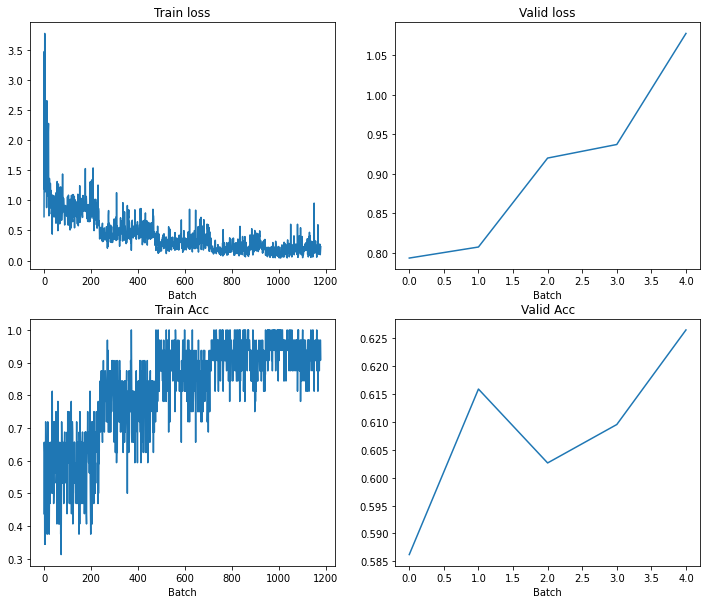

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Модель явно переобучается, так как при отличных результатах на трейне у нее  нет улучшений на валидации. На тесте она показывает результаты хуже, чем константа.

Увеличу размер скрытого слоя до 768.

In [ ]:
freeze_type = 'all'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=768, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'all_frozen_1_head_hid_768_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 0.981272 train_acc: 0.500000
EPOCH 0 STEP 100 : train_loss: 1.439878 train_acc: 0.593750
EPOCH 0 STEP 150 : train_loss: 0.962488 train_acc: 0.562500
EPOCH 0 STEP 200 : train_loss: 0.958604 train_acc: 0.468750
EPOCH 0 : valid_acc: 0.641910
EPOCH 1 STEP 250 : train_loss: 0.395958 train_acc: 0.812500
EPOCH 1 STEP 300 : train_loss: 0.435004 train_acc: 0.812500
EPOCH 1 STEP 350 : train_loss: 0.556021 train_acc: 0.750000
EPOCH 1 STEP 400 : train_loss: 0.527333 train_acc: 0.718750
EPOCH 1 STEP 450 : train_loss: 0.453423 train_acc: 0.718750
EPOCH 1 : valid_acc: 0.594164
EPOCH 2 STEP 500 : train_loss: 0.241298 train_acc: 0.906250
EPOCH 2 STEP 550 : train_loss: 0.253658 train_acc: 0.843750
EPOCH 2 STEP 600 : train_loss: 0.222544 train_acc: 0.906250
EPOCH 2 STEP 650 : train_loss: 0.211816 train_acc: 0.937500
EPOCH 2 STEP 700 : train_loss: 0.285425 train_acc: 0.875000
EPOCH 2 : valid_acc: 0.631830
EPOCH 3 STEP 750 : train_loss: 0.172936 train_acc: 0.968750
EPOCH 3 STE

0.6


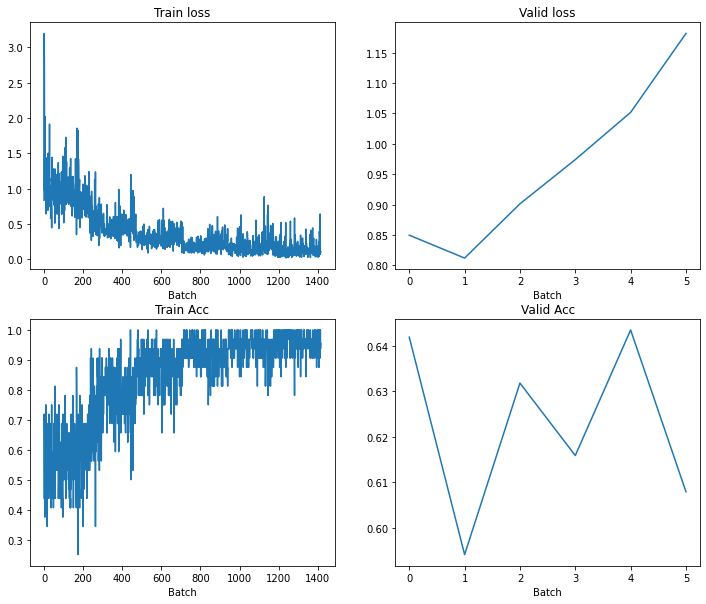

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Это не принесло дивидендов, так как у модели такие же проблемы, она показывает такой же плохой результат, но более тяжелая. Не будем трогать эту модификацию.

Теперь посмотрю 2 головы со скрытыми слоями в 384.

In [ ]:
freeze_type = 'all'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=2,
                                 hidden_dim=384, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'all_frozen_2_heads_hid_384_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 1.097728 train_acc: 0.656250
EPOCH 0 STEP 100 : train_loss: 0.756838 train_acc: 0.593750
EPOCH 0 STEP 150 : train_loss: 0.957619 train_acc: 0.625000
EPOCH 0 STEP 200 : train_loss: 1.666946 train_acc: 0.562500
EPOCH 0 : valid_acc: 0.540053
EPOCH 1 STEP 250 : train_loss: 0.609427 train_acc: 0.625000
EPOCH 1 STEP 300 : train_loss: 0.595713 train_acc: 0.656250
EPOCH 1 STEP 350 : train_loss: 0.525122 train_acc: 0.750000
EPOCH 1 STEP 400 : train_loss: 0.527835 train_acc: 0.687500
EPOCH 1 STEP 450 : train_loss: 0.735043 train_acc: 0.562500
EPOCH 1 : valid_acc: 0.590451
EPOCH 2 STEP 500 : train_loss: 0.400389 train_acc: 0.781250
EPOCH 2 STEP 550 : train_loss: 0.387237 train_acc: 0.875000
EPOCH 2 STEP 600 : train_loss: 0.518060 train_acc: 0.718750
EPOCH 2 STEP 650 : train_loss: 0.523069 train_acc: 0.718750
EPOCH 2 STEP 700 : train_loss: 0.388670 train_acc: 0.843750
EPOCH 2 : valid_acc: 0.604775
EPOCH 3 STEP 750 : train_loss: 0.165939 train_acc: 0.937500
EPOCH 3 STE

0.52


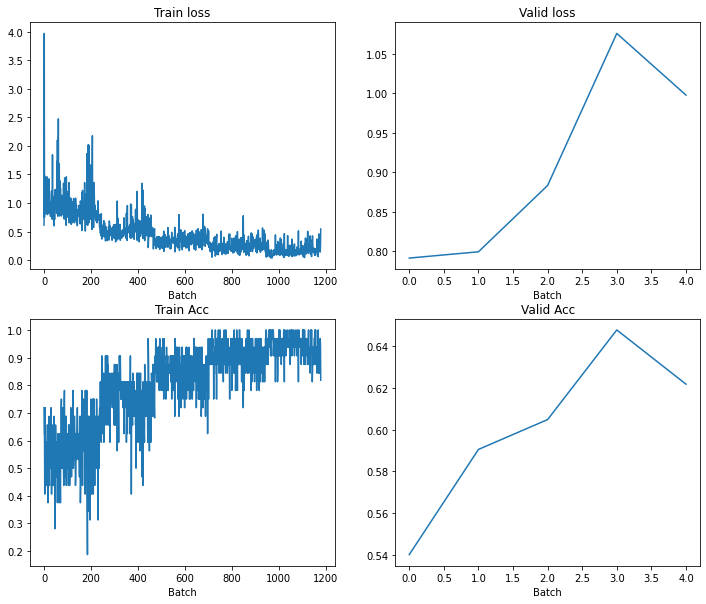

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Ситуация такая же, как у предыдущих сеток, но результат на тесте еще хуже. Почти как случайный классификатор. Явно 2 головы только все усложнили. Вернемся к 1 голове.

Сейчас я разморожу все параметры до эмбеддингов.

In [ ]:
freeze_type = 'emb'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=384, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'emb_frozen_1_head_hid_384_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 1.108683 train_acc: 0.468750
EPOCH 0 STEP 100 : train_loss: 1.085799 train_acc: 0.625000
EPOCH 0 STEP 150 : train_loss: 1.225793 train_acc: 0.687500
EPOCH 0 STEP 200 : train_loss: 0.955040 train_acc: 0.468750
EPOCH 0 : valid_acc: 0.611671
EPOCH 1 STEP 250 : train_loss: 0.522683 train_acc: 0.687500
EPOCH 1 STEP 300 : train_loss: 0.642390 train_acc: 0.687500
EPOCH 1 STEP 350 : train_loss: 0.303550 train_acc: 0.875000
EPOCH 1 STEP 400 : train_loss: 0.411218 train_acc: 0.781250
EPOCH 1 STEP 450 : train_loss: 0.453421 train_acc: 0.781250
EPOCH 1 : valid_acc: 0.605305
EPOCH 2 STEP 500 : train_loss: 0.294248 train_acc: 0.906250
EPOCH 2 STEP 550 : train_loss: 0.352501 train_acc: 0.812500
EPOCH 2 STEP 600 : train_loss: 0.153269 train_acc: 0.937500
EPOCH 2 STEP 650 : train_loss: 0.313300 train_acc: 0.843750
EPOCH 2 STEP 700 : train_loss: 0.416330 train_acc: 0.843750
EPOCH 2 : valid_acc: 0.621220
EPOCH 3 STEP 750 : train_loss: 0.133080 train_acc: 0.968750
EPOCH 3 STE

0.62


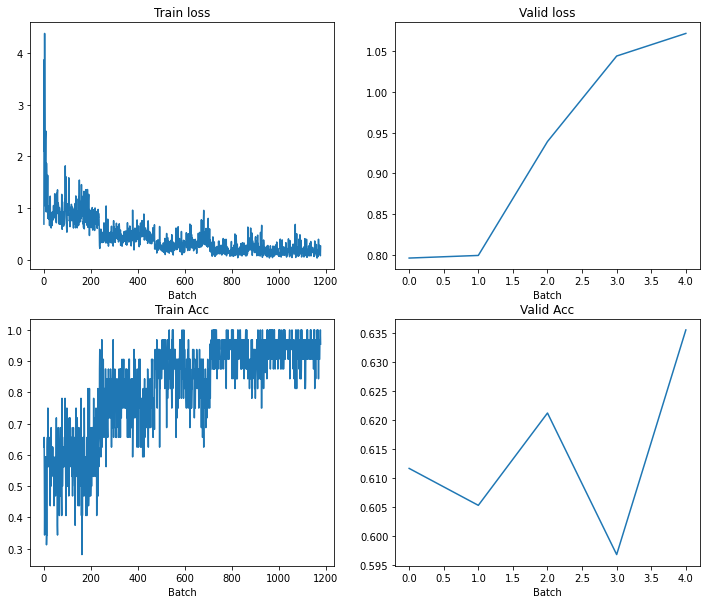

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Модель улучшила результат хотя бы до константного, но сохраняет все предыдущие проблемы. Тем не менее, выберу такую модификацию как приоритет.

Далее буду размораживать bert-transformer часть только с 3 эпохи обучения.

In [32]:
hyperparams = {'lr': 1e-4, 'batch_size': 16, 'epochs': 10}
freeze_type = 'part'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=384, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'part_frozen_1_head_hid_384_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 0.574130 train_acc: 0.687500
EPOCH 0 STEP 100 : train_loss: 1.073448 train_acc: 0.437500
EPOCH 0 STEP 150 : train_loss: 0.688657 train_acc: 0.687500
EPOCH 0 STEP 200 : train_loss: 0.462834 train_acc: 0.750000
EPOCH 0 STEP 250 : train_loss: 0.705688 train_acc: 0.562500
EPOCH 0 STEP 300 : train_loss: 0.911721 train_acc: 0.437500
EPOCH 0 STEP 350 : train_loss: 0.578358 train_acc: 0.687500
EPOCH 0 STEP 400 : train_loss: 0.683591 train_acc: 0.687500
EPOCH 0 STEP 450 : train_loss: 0.587295 train_acc: 0.687500
EPOCH 0 : valid_acc: 0.653581
EPOCH 1 STEP 500 : train_loss: 0.425247 train_acc: 0.750000
EPOCH 1 STEP 550 : train_loss: 0.543844 train_acc: 0.687500
EPOCH 1 STEP 600 : train_loss: 0.246859 train_acc: 0.937500
EPOCH 1 STEP 650 : train_loss: 0.401209 train_acc: 0.875000
EPOCH 1 STEP 700 : train_loss: 0.751246 train_acc: 0.625000
EPOCH 1 STEP 750 : train_loss: 0.566308 train_acc: 0.812500
EPOCH 1 STEP 800 : train_loss: 0.462571 train_acc: 0.750000
EPOCH 1 STE

In [33]:
from google.colab import files
files.download('/content/part_frozen_1_head_hid_384_distilbert_best-val-model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.67


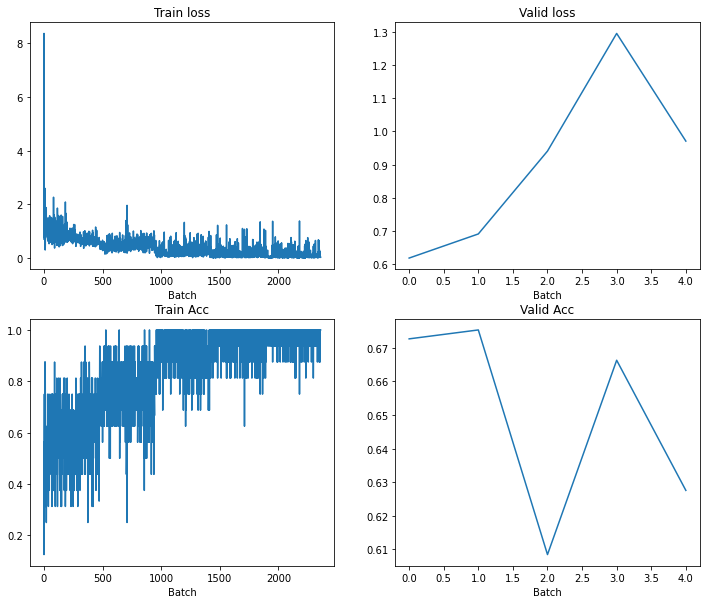

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Такая модель уже показывает результаты наравне с fasttext, хотя у нее все такие же проблемы. Но эта модель лучше всех моделей в этом пункте на данный момент. Выберу ее. 

Теперь попробую разморозить вообще все слои.

In [ ]:
hyperparams = {'lr': 1e-4, 'batch_size': 16, 'epochs': 10}
freeze_type = 'none'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=384, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'none_frozen_1_head_hid_384_distilbert')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 0.860260 train_acc: 0.562500
EPOCH 0 STEP 100 : train_loss: 0.824882 train_acc: 0.750000
EPOCH 0 STEP 150 : train_loss: 0.734411 train_acc: 0.750000
EPOCH 0 STEP 200 : train_loss: 1.129322 train_acc: 0.375000
EPOCH 0 STEP 250 : train_loss: 0.633680 train_acc: 0.687500
EPOCH 0 STEP 300 : train_loss: 0.943243 train_acc: 0.375000
EPOCH 0 STEP 350 : train_loss: 0.662918 train_acc: 0.687500
EPOCH 0 STEP 400 : train_loss: 0.746828 train_acc: 0.562500
EPOCH 0 STEP 450 : train_loss: 0.525621 train_acc: 0.812500
EPOCH 0 : valid_acc: 0.653581
EPOCH 1 STEP 500 : train_loss: 0.553997 train_acc: 0.750000
EPOCH 1 STEP 550 : train_loss: 0.401165 train_acc: 0.750000
EPOCH 1 STEP 600 : train_loss: 0.811650 train_acc: 0.687500
EPOCH 1 STEP 650 : train_loss: 0.652895 train_acc: 0.687500
EPOCH 1 STEP 700 : train_loss: 0.449267 train_acc: 0.812500
EPOCH 1 STEP 750 : train_loss: 0.270606 train_acc: 0.937500
EPOCH 1 STEP 800 : train_loss: 0.377012 train_acc: 0.812500
EPOCH 1 STE

0.66


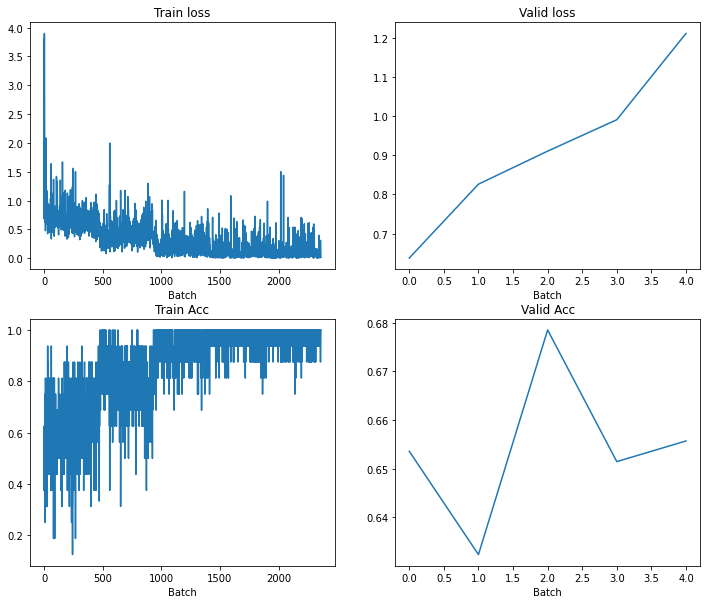

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Это не улучшило предыдущий показатель, хотя модель не сильно отстает от лучшей модели в этом направлении, а также от моделей на fasttext. Тем не менее, она сложнее, чем предыдущая и в ней больше обучаемых параметров, поэтому не буду ее выбирать.

Сейчас попробую использовать Roberta.

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert = RobertaModel.from_pretrained('roberta-base')

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer)
valid_dataset = CustomDataset(val_df, tokenizer)
dev_dataset = CustomDataset(dev_df, tokenizer)

Обучу на лучших параметрах для DistilBert.

In [ ]:
hyperparams = {'lr': 1e-4, 'batch_size': 8, 'epochs': 10}
freeze_type = 'part'
model = QuestAnsweringDistilBERT(bert, config, freeze_type, n_layers=1,
                                 hidden_dim=384, dim=768)
model_pipe = Model_Pipe(train_dataset, valid_dataset, dev_dataset,
                        model, hyperparams, freeze_type,
                        'part_frozen_1_head_hid_384_roberta')
history = model_pipe.run_train()

EPOCH 0 STEP 50 : train_loss: 0.660467 train_acc: 0.625000
EPOCH 0 STEP 100 : train_loss: 1.655990 train_acc: 0.250000
EPOCH 0 STEP 150 : train_loss: 0.689651 train_acc: 0.625000
EPOCH 0 STEP 200 : train_loss: 0.670205 train_acc: 0.625000
EPOCH 0 STEP 250 : train_loss: 0.549037 train_acc: 0.875000
EPOCH 0 STEP 300 : train_loss: 0.696107 train_acc: 0.625000
EPOCH 0 STEP 350 : train_loss: 0.709085 train_acc: 0.625000
EPOCH 0 STEP 400 : train_loss: 0.900913 train_acc: 0.625000
EPOCH 0 STEP 450 : train_loss: 0.990798 train_acc: 0.625000
EPOCH 0 STEP 500 : train_loss: 0.786503 train_acc: 0.500000
EPOCH 0 STEP 550 : train_loss: 0.543452 train_acc: 0.750000
EPOCH 0 STEP 600 : train_loss: 0.726578 train_acc: 0.375000
EPOCH 0 STEP 650 : train_loss: 0.536103 train_acc: 0.750000
EPOCH 0 STEP 700 : train_loss: 0.918845 train_acc: 0.500000
EPOCH 0 STEP 750 : train_loss: 0.907917 train_acc: 0.625000
EPOCH 0 STEP 800 : train_loss: 1.544864 train_acc: 0.375000
EPOCH 0 STEP 850 : train_loss: 0.721433 t

0.62


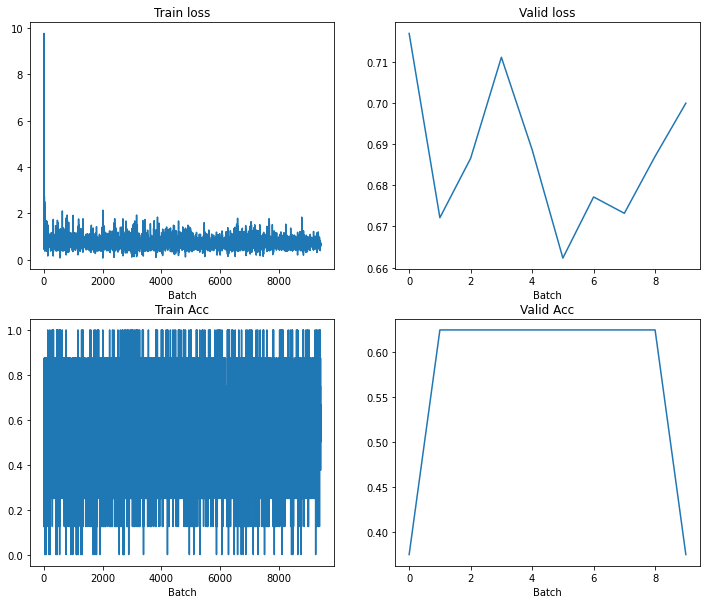

In [ ]:
print(round(model_pipe.test(), 2))
draw(history)

Я использовал маленький размер батча, так как больший размер приводил к переполнению памяти. Это могло повлиять на качество обучения, которое, возможно, проявляется в нестабильном accuracy на трейне и отсутствию уменьшения в лоссе. На валидации лосс падал, но на точности модели это не сказывалось в лучшую сторону. Результат примерно как константный, что говорит, что модель ничему не научилась. Здесь Roberta явно проиграла DistilBert.